In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/anaconda3/envs/fastcampus/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/fastcampus/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def plot_scatter(W_, xy, labels):
    for k, color in [(0, 'b'), (1, 'r')]:
        idx = labels.flatten() == k
        plt.scatter(xy[idx, 0], xy[idx, 1], c=color)

    if W_ is not None:
        x1 = np.linspace(-.1, 1.1)
        x2 = -W_[1] / W_[2] * x1  - W_[0] / W_[2]
        plt.plot(x1, x2, '--k')

    plt.grid()
    plt.show()

In [3]:
np.random.seed(402)
xy = np.random.rand(30,2)
labels = np.zeros((len(xy),1))
labels[-4./5. +  3./4. * xy[:,0] + 1.0 * xy[:,1] > 0, 0] = 1

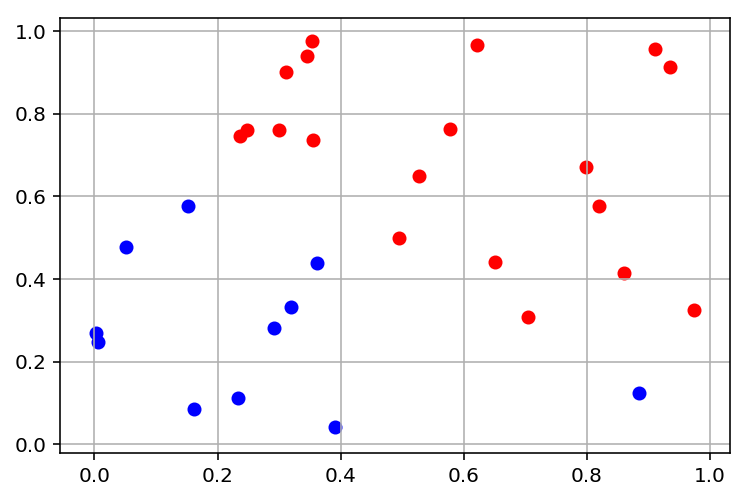

In [4]:
plot_scatter(None, xy, labels)

## Sigmoid Without Bias

In [5]:
features1 = np.array([[1.0, xval, yval] for xval, yval in xy])

x = tf.placeholder(tf.float32, shape=(None, 3))
y = tf.placeholder(tf.float32, shape=(None, 1))

W = tf.Variable(tf.ones([3, 1]), dtype=tf.float32)

model = tf.nn.sigmoid(tf.matmul(x, W))

loss = tf.reduce_mean(- y * tf.log(model) - (1 - y) * tf.log(1-model))

In [6]:
lr = 0.1
MaxEpochs= 201
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
np.random.seed(702)
idx = np.arange(0, len(features1))
np.random.shuffle(idx)
shuffled_features = features1[idx]
shuffled_labels = labels[idx]

batch_size = 5
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    out = sess.run([model, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
    for epoch in range(MaxEpochs):
        if epoch % 50 == 0 :
            curr_W, curr_loss = sess.run([W, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
            print(epoch, curr_W.flatten(), curr_loss)
        for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
            sess.run(train, feed_dict={x: x_batch, y: y_batch})

    curr_W = sess.run(W)
W_sgd = curr_W.flatten()

0 [1. 1. 1.] 0.6979387
50 [-4.963288   4.568311   7.4219847] 0.1727642
100 [-7.222922  6.479261 10.30485 ] 0.123371385
150 [-8.847088  7.858345 12.387743] 0.101031594
200 [-10.179716   9.000248  14.100651] 0.08736823


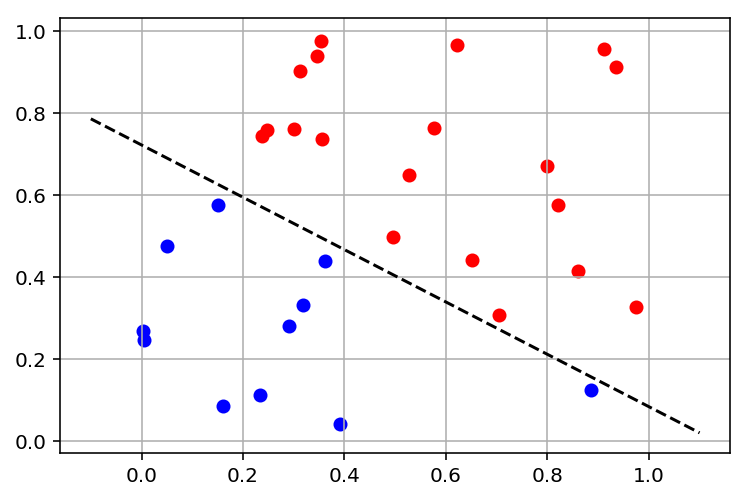

In [7]:
plot_scatter(W_sgd, xy, labels)

## Sigmoid With Bias

In [8]:
features2 = np.array([[xval, yval] for xval, yval in xy])

x = tf.placeholder(tf.float32, shape=(None, 2))
y = tf.placeholder(tf.float32, shape=(None, 1))

W = tf.Variable(tf.ones([2, 1]), dtype=tf.float32)
b = tf.Variable(tf.ones([1]), dtype=tf.float32)

model = tf.nn.sigmoid(tf.matmul(x, W) + b)

loss = tf.reduce_mean(- y * tf.log(model) - (1 - y) * tf.log(1-model))

In [9]:
lr = 0.1
MaxEpochs= 201
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
np.random.seed(702)
idx = np.arange(0, len(features2))
np.random.shuffle(idx)
shuffled_features = features2[idx]
shuffled_labels = labels[idx]

batch_size = 5
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    out = sess.run([model, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
    for epoch in range(MaxEpochs):
        if epoch % 50 == 0 :
            curr_b, curr_W, curr_loss = sess.run([b, W, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
            print(epoch, curr_b.flatten(), curr_W.flatten(), curr_loss)
        for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
            sess.run(train, feed_dict={x: x_batch, y: y_batch})

    curr_b, curr_W = sess.run([b, W])
W_sgd = curr_W.flatten()
b_sgd = curr_b.flatten()

0 [1.] [1. 1.] 0.6979387
50 [-4.9632883] [4.5683117 7.421985 ] 0.17276415
100 [-7.222922] [ 6.4792614 10.304851 ] 0.12337138
150 [-8.847088] [ 7.8583455 12.387743 ] 0.10103159
200 [-10.179716] [ 9.000248 14.100651] 0.08736823


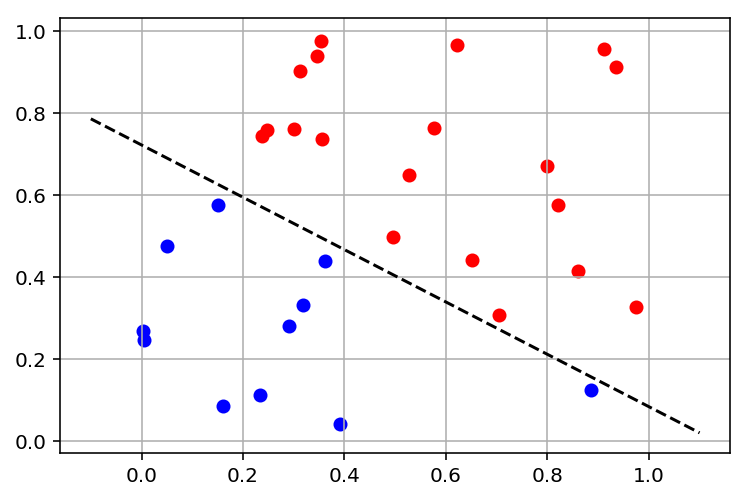

In [10]:
plot_scatter(np.append(b_sgd, W_sgd), xy, labels)

# Cross Entropy with Softmax

In [11]:
np.random.seed(402)
xy = np.random.rand(30,2)
labels = np.zeros((len(xy),2))
labels[-4./5. +  3./4. * xy[:,0] + 1.0 * xy[:,1] > 0, 0] = 1.
labels[-4./5. +  3./4. * xy[:,0] + 1.0 * xy[:,1] <= 0, 1] = 1.
# Notice one-hot encoding
labels[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [12]:
def plot_scatter_softmax(curr_W, curr_b, xy, labels):
    x1 = np.linspace(-0.1, 1.1)
    X, Y = np.meshgrid(x1,x1)
    print(curr_W)
    Z1 = X * curr_W[0,0] + Y * curr_W[1,0] + curr_b[0]
    Z2 = X * curr_W[0,1] + Y * curr_W[1,1] + curr_b[1]
    Z = np.exp(Z2) / (np.exp(Z1) + np.exp(Z2))

    plt.figure(figsize=(5,5))
    cs = plt.contourf(X, Y, Z, np.linspace(0, 1, 11), cmap='coolwarm')
    plt.clabel(cs, colors='k')
    for k, color in [(0, 'b'), (1, 'r')]:
        idx = labels[:, k] == 1
        plt.scatter(xy[idx, 0], xy[idx, 1], c=color, edgecolors='k')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.show()

## Cross Entropy with Softmax without logits

In [13]:
features = np.array([[xval, yval] for xval, yval in xy])

x = tf.placeholder(tf.float32, shape=(None, 2))
y = tf.placeholder(tf.float32, shape=(None, 2))

W = tf.Variable(tf.ones([2, 2]), dtype=tf.float32)
b = tf.Variable(tf.ones([2]), dtype=tf.float32)

model = tf.nn.softmax(tf.matmul(x, W) + b)

loss = tf.reduce_mean(tf.reduce_sum(-y * tf.log(model), 1))

In [14]:
lr = 1.0
MaxEpochs= 201
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
np.random.seed(702)
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels[idx]

batch_size = 5
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    out = sess.run([model, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
    for epoch in range(MaxEpochs):
        if epoch % 50 == 0 :
            curr_b, curr_W, curr_loss = sess.run([b, W, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
            print(epoch, curr_b.flatten(), curr_W.flatten(), curr_loss)
        
        for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
            sess.run(train, feed_dict={x: x_batch, y: y_batch})

    curr_b, curr_W = sess.run([b, W])
W_sgd = curr_W
b_sgd = curr_b

0 [1. 1.] [1. 1. 1. 1.] 0.6931471
50 [-8.587664 10.587667] [  9.5475025  -7.547498   14.09965   -12.09965  ] 0.042455312
100 [-12.20891   14.208908] [ 12.718837 -10.718831  19.04896  -17.048954] 0.027281778
150 [-15.08129   17.081293] [ 15.229489 -13.22948   23.041456 -21.041454] 0.019864636
200 [-17.57223   19.572233] [ 17.402678 -15.40268   26.536247 -24.536263] 0.015250495


[[ 17.443684 -15.443685]
 [ 26.602451 -24.602467]]


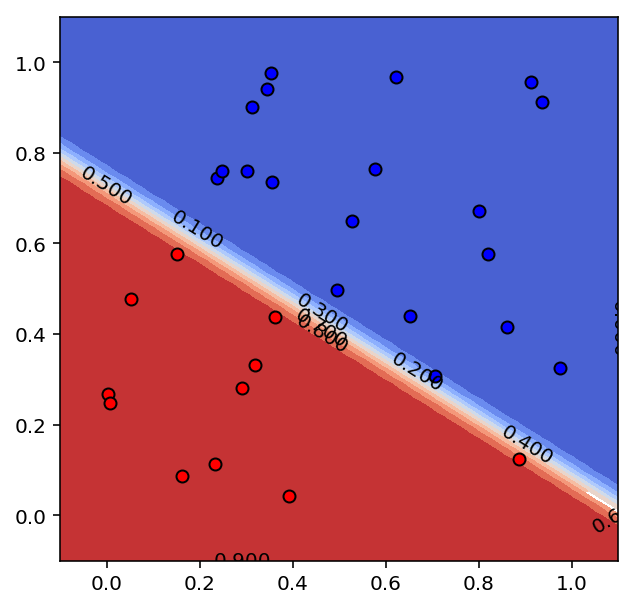

In [15]:
plot_scatter_softmax(W_sgd, b_sgd, xy, labels)

## Cross Entropy with Softmax with logits

In [16]:
features = np.array([[xval, yval] for xval, yval in xy])

x = tf.placeholder(tf.float32, shape=(None, 2))
y = tf.placeholder(tf.float32, shape=(None, 2))

W = tf.Variable(tf.ones([2, 2]), dtype=tf.float32)
b = tf.Variable(tf.ones([2]), dtype=tf.float32)

logits = tf.matmul(x, W) + b

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [17]:
lr = 1.0
MaxEpochs= 201
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
np.random.seed(702)
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels[idx]

batch_size = 5
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)    
    for epoch in range(MaxEpochs):
        if epoch % 50 == 0 :
            curr_b, curr_W, curr_loss = sess.run([b, W, loss], feed_dict={x: shuffled_features, y: shuffled_labels})
            print(epoch, curr_b.flatten(), curr_W.flatten(), curr_loss)
        
        for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
            sess.run(train, feed_dict={x: x_batch, y: y_batch})

    curr_b, curr_W = sess.run([b, W])
W_sgd = curr_W
b_sgd = curr_b

0 [1. 1.] [1. 1. 1. 1.] 0.6931471
50 [-8.5876665 10.587663 ] [  9.547499  -7.547499  14.099645 -12.099652] 0.042455297
100 [-12.208911   14.2088995] [ 12.71883  -10.718835  19.04894  -17.048962] 0.02728179
150 [-15.081294  17.081285] [ 15.229483 -13.229485  23.041443 -21.04146 ] 0.01986464
200 [-17.572243  19.572233] [ 17.402683 -15.402684  26.536247 -24.536276] 0.015250476


[[ 17.44369  -15.443688]
 [ 26.602451 -24.60248 ]]


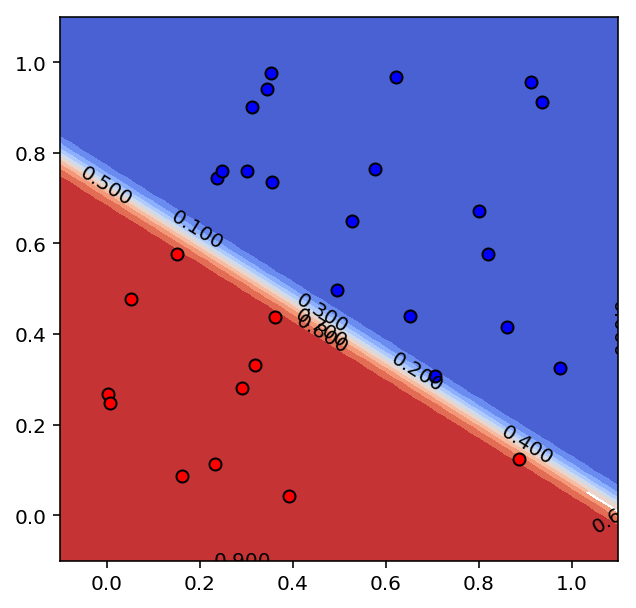

In [18]:
plot_scatter_softmax(W_sgd, b_sgd, xy, labels)